In [331]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [269]:
df_sirs = pd.read_excel('Dartmouth Data Set- SIRS .xlsx')

In [270]:
xls = pd.ExcelFile('Dartmouth Data Set- SIRS .xlsx')
df1 = pd.read_excel(xls, 'Emergency Crisis Services')
df_dem = pd.read_excel(xls, 'Demographics')

In [272]:
df_dem.keys()

Index(['Local ID', 'Date Enrolled in START', 'Status', 'Status Date',
       'Time Enrolled in START', 'Source of referral to START',
       'Suitability of enrollment in START',
       'Individual/Caregiver reliable access to technology',
       'Presenting problems at time of enrollment', 'Services at Enrollment',
       'DOB', 'Gender', 'Race', 'Ethnicity',
       'Level of Intellectual Disability',
       'Current living situation at enrollment to START',
       'More than one living situation over the last 5 years?',
       'More than one living situation over the last year?',
       'Psychiatric hospitalization in past year (at enrollment to START)',
       'Psychiatric hospitalizations in past 1 - 5 years (at enrollment to START)',
       'Emergency department visits in past year (at enrollment to START)',
       'Emergency department visits in past 1-5 years (at enrollment to START)',
       'Law enforcement encounters in past year (at enrollment to START)',
       'Law enforce

In [275]:
df_dem1 = df_dem[['Local ID', 'Gender', 'Race', 'Ethnicity',
       'Level of Intellectual Disability',
       'Current living situation at enrollment to START',
       'More than one living situation over the last 5 years?',
       'More than one living situation over the last year?']]

In [247]:
df1.keys()
date = 'Date/Time of Contact'
hospital_diversion = "Did START response prevent higher level of care (hospital diversion)"

Index(['Individual ID', 'Date/Time of Contact', 'Source of Contact',
       'Reason for Contact', 'Type of Emergency Response',
       'Total episode length (initial call to disposition)',
       'Total response time (initial call to arrival on-site)', 'Travel Time',
       'Police Response', 'If Police Responded', 'Who Contacted Police?',
       'Mobile Crisis', 'If Mobile Crisis', 'Restraints Used',
       'If Restraints Were Used', 'Disposition', 'Disposition Information',
       'Admitted through ED/CPEP', 'Date of Admission',
       'Disposition Information (ER)',
       'Did START response prevent higher level of care (hospital diversion)',
       'RSQ Completed?'],
      dtype='object')

In [276]:
df1[hospital_diversion].value_counts()

Did START response prevent higher level of care (hospital diversion)
No     10237
Yes     7931
Name: count, dtype: int64

In [277]:
df1_clean = df1[["Individual ID", date, hospital_diversion, "Reason for Contact"]].copy()

In [278]:
df1_clean["Reason for Contact"] = df1_clean["Reason for Contact"].str.replace("Aggression (physical, verbal, property destruction, threats)", "Aggression")
df1_clean['Reason for Contact'] = df1_clean['Reason for Contact'].str.lower()
df1_clean["Reason for Contact"] = df1_clean["Reason for Contact"].str.replace(r'(other:)?\s*?(change\s*(of|in)?\s*)?mood(\s*change)?', 'mood change', regex=True)


In [279]:
df1_clean[df1_clean["Reason for Contact"].str.contains('mood')==True]

,Individual ID,Date/Time of Contact,Did START response prevent higher level of care (hospital diversion),Reason for Contact
1380,629785C,2018-05-24 12:20:00,Yes,"aggression, other: changes inmood change, leaving unexpectedly"
1629,375509,2018-03-16 18:20:00,No,"aggression, mood change"
1635,375509,2018-02-27 18:00:00,No,"mood change , self-injurious"
1638,375509,2018-04-26 16:30:00,No,"other: increase of anxiety,mood change"
1659,375509,2017-12-18 21:00:00,No,"aggression, mood change"
...,...,...,...,...
17854,906566E,2021-10-25 09:45:00,No,"aggression, family needs assistance, mood change, suicidal ideation/behaviors"
17881,6236749,2021-10-29 16:26:00,Yes,"aggression, mood change, property destruction, and threats to harm others (father)"
17895,243197C,2021-11-02 15:30:00,No,"aggression, mood change"
17933,906566E,2021-11-10 13:45:00,No,"aggression, mood change, self-injurious"


In [280]:
df1_clean['Reason for Contact'].fillna("Unknown", inplace=True)

In [281]:
def checker(df, word):
    # Create the 'is_blank' column based on whether 'Reason for Contact' contains the word
    column_name = 'is_' + str(word)
    print(column_name)
    df[column_name] = df['Reason for Contact'].str.contains(word)
    return df


In [428]:
categories = ['aggression', 'mental health symptoms', 'family needs assistance', 'suicidal', 'self-injurious', 'decrease in ability to participate in daily functions', 'risk of losing placement', 'mood']

df2 = df1_clean.apply(lambda row: pd.Series({
    'Individual ID': row['Individual ID'],
    'Date/Time of Contact': row['Date/Time of Contact'],
    'Reason for Contact': row['Reason for Contact'],
    'Did START response prevent higher level of care (hospital diversion)': row['Did START response prevent higher level of care (hospital diversion)'],
    **{f'is_{cat}': cat.lower() in row['Reason for Contact'].lower() for cat in categories}
}), axis=1)


In [429]:
df2['is_other'] = df2['Reason for Contact'].apply(lambda x: True if 'other' in x.lower() else False)

In [431]:
df2

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_decrease in ability to participate in daily functions,is_risk of losing placement,is_mood,is_other
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",No,False,False,False,False,True,False,True,False,True
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",Yes,False,True,False,False,True,False,False,False,False
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",Yes,False,True,False,True,False,False,False,False,False
3,11158347,2015-06-01 14:00:00,"diagnosis and treatment plan assistance, other: facilitating med ajustment w/ center",No,False,False,False,False,False,False,False,False,True
4,11158347,2015-06-01 16:00:00,"aggression, family needs assistance, mental health symptoms",No,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18163,108482C,2021-12-03 14:05:00,"aggression, mental health symptoms",Yes,True,True,False,False,False,False,False,False,False
18164,817731C,2021-12-04 14:21:00,"family needs assistance, mental health symptoms",Yes,False,True,True,False,False,False,False,False,False
18165,471473,2021-12-19 15:00:00,mental health symptoms,No,False,True,False,False,False,False,False,False,False
18166,780879W,2021-12-17 11:00:00,"at risk of losing placement, decrease in ability to participate in daily functions, diagnosis and treatment plan assistance, mental health symptoms, self-injurious, suicidal ideation/behaviors",No,False,True,False,True,True,True,True,False,False


In [432]:
df1_clean['Reason for Contact'].str.split(', ').explode().str.lower().value_counts(normalize=True).head(30)

Reason for Contact
aggression                                                  0.325284
mental health symptoms                                      0.196120
family needs assistance                                     0.118616
suicidal ideation/behaviors                                 0.060850
self-injurious                                              0.055545
decrease in ability to participate in daily functions       0.049069
at risk of losing placement                                 0.028343
other                                                       0.020047
mood change                                                 0.019954
transition from hospital                                    0.012367
medical concerns                                            0.009345
other: leaving unexpectedly                                 0.007865
diagnosis and treatment plan assistance                     0.006415
unknown                                                     0.005706
medication eval

In [433]:
df2.keys()
df_dem1.keys()

Index(['Individual ID', 'Date/Time of Contact', 'Reason for Contact',
       'Did START response prevent higher level of care (hospital diversion)',
       'is_aggression', 'is_mental health symptoms',
       'is_family needs assistance', 'is_suicidal', 'is_self-injurious',
       'is_decrease in ability to participate in daily functions',
       'is_risk of losing placement', 'is_mood', 'is_other'],
      dtype='object')

Index(['Local ID', 'Gender', 'Race', 'Ethnicity',
       'Level of Intellectual Disability',
       'Current living situation at enrollment to START',
       'More than one living situation over the last 5 years?',
       'More than one living situation over the last year?'],
      dtype='object')

In [450]:
df_merged = pd.merge(df2, df_dem1, left_on="Individual ID", right_on= "Local ID", how='inner')


df_merged.replace({'Yes': 1, 'No': 0}, inplace=True)
df_merged

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_decrease in ability to participate in daily functions,...,is_mood,is_other,Local ID,Gender,Race,Ethnicity,Level of Intellectual Disability,Current living situation at enrollment to START,More than one living situation over the last 5 years?,More than one living situation over the last year?
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",0,False,False,False,False,True,False,...,False,True,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",1,False,True,False,False,True,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",1,False,True,False,True,False,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
3,11153125,2019-07-18 10:30:00,"diagnosis and treatment plan assistance, mental health symptoms, suicidal ideation/behaviors",0,False,True,False,True,False,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
4,11153125,2019-07-17 17:35:00,"self-injurious, suicidal ideation/behaviors",1,False,False,False,True,True,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14488,167376,2021-12-08 09:30:00,"aggression, decrease in ability to participate in daily functions",1,True,False,False,False,False,True,...,False,False,167376,Male,Black or African American,Not of Hispanic origin,Profound,Group home,1,Yes: 2
14489,383243E,2021-12-10 10:45:00,"aggression, at risk of losing placement, mental health symptoms",0,True,True,False,False,False,False,...,False,False,383243E,Male,White,Not of Hispanic origin,Mild,Group home,1,0
14490,809219C,2021-12-10 16:20:00,"aggression, family needs assistance",1,True,False,True,False,False,False,...,False,False,809219C,Male,White,Not of Hispanic origin,Mild,Family home,0,0
14491,407330,2021-12-15 10:28:00,"other: summer did not show up to school and given concerns with safety, the school was concerned. mom was not answering the phone",0,False,False,False,False,False,False,...,False,True,407330,Female,White,Hispanic - specific origin not specified,Moderate,Family home,1,0


In [451]:
df_pre = df_merged[(df_merged['Date/Time of Contact'] > '2019-03-01 00:00:00') & (df_merged['Date/Time of Contact'] < '2020-03-01 00:00:00')]

In [452]:
df_post = df_merged[(df_merged['Date/Time of Contact'] > '2020-03-02 00:00:00') & (df_merged['Date/Time of Contact'] < '2021-03-01 00:00:00')]

In [453]:
df_merged

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_decrease in ability to participate in daily functions,...,is_mood,is_other,Local ID,Gender,Race,Ethnicity,Level of Intellectual Disability,Current living situation at enrollment to START,More than one living situation over the last 5 years?,More than one living situation over the last year?
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",0,False,False,False,False,True,False,...,False,True,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",1,False,True,False,False,True,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",1,False,True,False,True,False,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
3,11153125,2019-07-18 10:30:00,"diagnosis and treatment plan assistance, mental health symptoms, suicidal ideation/behaviors",0,False,True,False,True,False,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
4,11153125,2019-07-17 17:35:00,"self-injurious, suicidal ideation/behaviors",1,False,False,False,True,True,False,...,False,False,11153125,Female,White,Not of Hispanic origin,Mild,Alternative Family Living (AFL),1,Yes: 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14488,167376,2021-12-08 09:30:00,"aggression, decrease in ability to participate in daily functions",1,True,False,False,False,False,True,...,False,False,167376,Male,Black or African American,Not of Hispanic origin,Profound,Group home,1,Yes: 2
14489,383243E,2021-12-10 10:45:00,"aggression, at risk of losing placement, mental health symptoms",0,True,True,False,False,False,False,...,False,False,383243E,Male,White,Not of Hispanic origin,Mild,Group home,1,0
14490,809219C,2021-12-10 16:20:00,"aggression, family needs assistance",1,True,False,True,False,False,False,...,False,False,809219C,Male,White,Not of Hispanic origin,Mild,Family home,0,0
14491,407330,2021-12-15 10:28:00,"other: summer did not show up to school and given concerns with safety, the school was concerned. mom was not answering the phone",0,False,False,False,False,False,False,...,False,True,407330,Female,White,Hispanic - specific origin not specified,Moderate,Family home,1,0


In [454]:
df_merged['Date/Time of Contact'] = pd.to_datetime(df_merged['Date/Time of Contact'])
df_merged.set_index('Date/Time of Contact', inplace=True)


In [455]:
# Group by week and aggregate specific columns differently
weekly_grouped = df_merged.resample('M').agg({
    'Individual ID': 'count',  # Count of entries per week
    'is_aggression': 'sum',
    'is_mental health symptoms' : 'sum',
    'is_family needs assistance' : 'sum',
    'is_suicidal' : 'sum',
    'is_self-injurious' : 'sum',
    'is_decrease in ability to participate in daily functions' : 'sum',
    'is_risk of losing placement' : 'sum',
    'is_mood' : 'sum',
    'is_other' : 'sum',
    'Did START response prevent higher level of care (hospital diversion)' : 'sum'
    
})

# Reset the index if you want 'Date/Time of Contact' back as a column
weekly_grouped.reset_index(inplace=True)

weekly_grouped = weekly_grouped[(weekly_grouped['Date/Time of Contact'] > '2019-03-02 00:00:00')]


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

Text(0.5, 1.0, 'Weekly Sum of Categorical Events')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Count')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

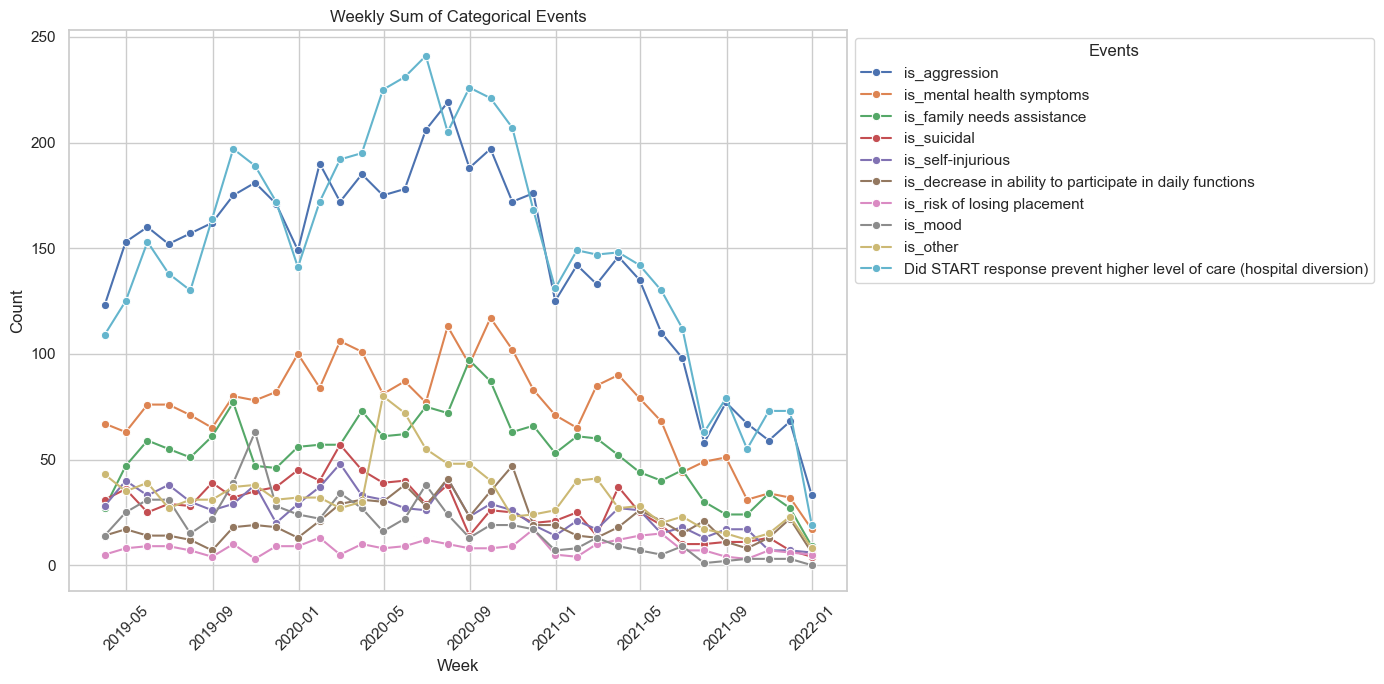

In [456]:
plt.figure(figsize=(14, 7))

# Plot each categorical column
for column in weekly_grouped.columns[2:]:
    sns.lineplot(x='Date/Time of Contact', y=column, data=weekly_grouped, marker='o', label=column)

plt.title('Weekly Sum of Categorical Events')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Events')
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

Text(0.5, 1.0, 'Weekly Proportion of Categorical Events')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Proportion')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

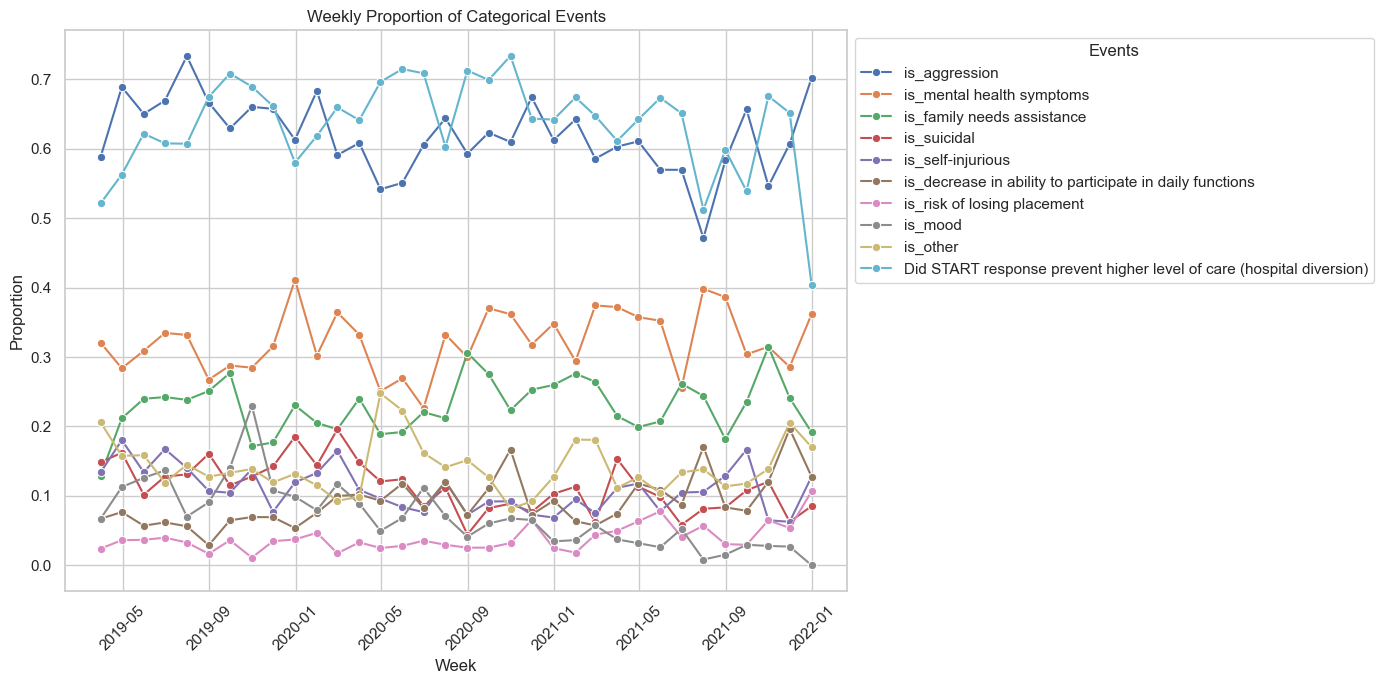

In [457]:
# Normalize each 'is_...' column by 'Individual ID' counts
cols_to_normalize = weekly_grouped.columns[2:]  # Assuming columns to normalize are from the 3rd column onwards

weekly_grouped[cols_to_normalize] = weekly_grouped[cols_to_normalize].div(weekly_grouped['Individual ID'], axis=0)

# Set the style
sns.set(style="whitegrid")

# Plot multiple line graphs
plt.figure(figsize=(14, 7))

# Plot each categorical column
for column in cols_to_normalize:
    sns.lineplot(x='Date/Time of Contact', y=column, data=weekly_grouped, marker='o', label=column)

plt.title('Weekly Proportion of Categorical Events')
plt.xlabel('Week')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Events')
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='Individual ID'>

Text(0.5, 1.0, 'Weekly Count of Individual ID')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Count of Individual ID')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

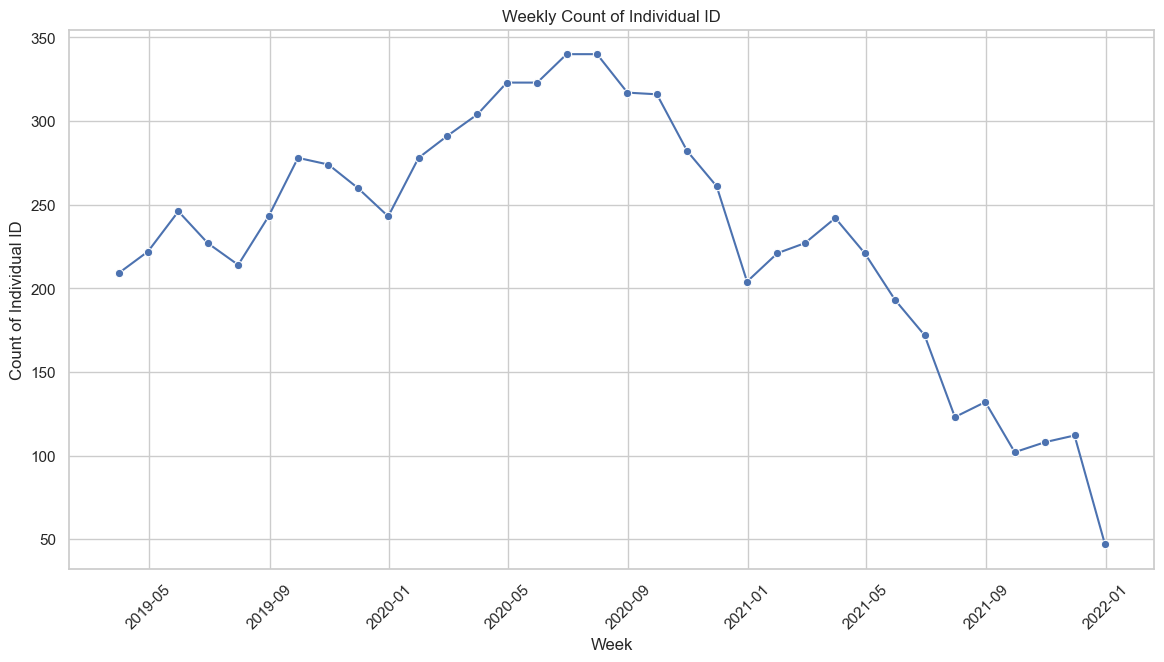

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>) -> None

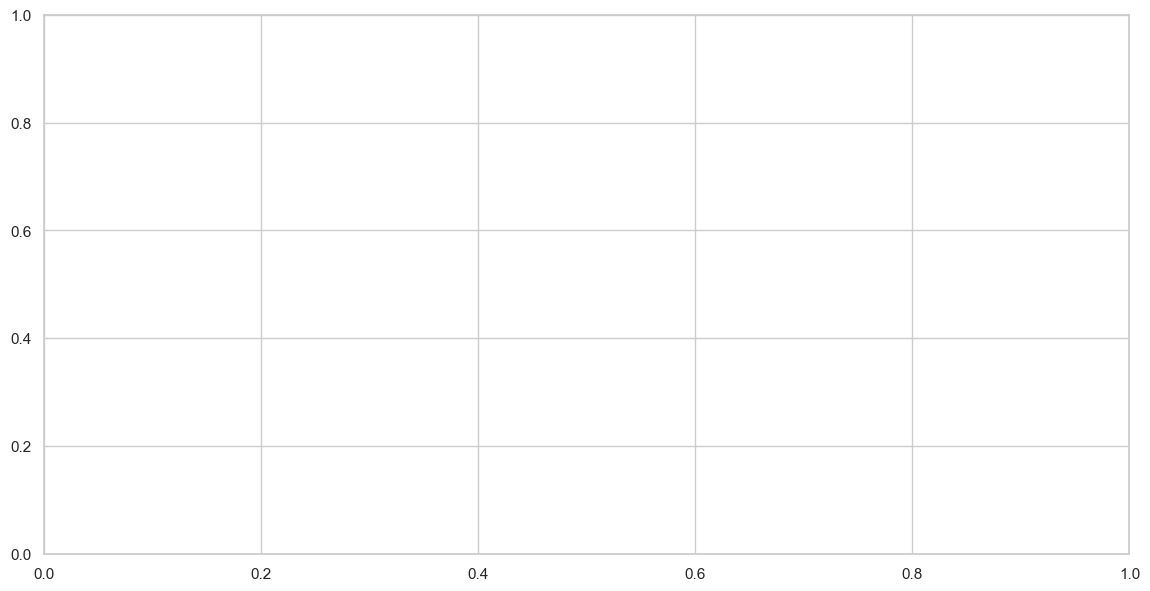

In [458]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date/Time of Contact', y='Individual ID', data=weekly_grouped, marker='o')
plt.title('Weekly Count of Individual ID')
plt.xlabel('Week')
plt.ylabel('Count of Individual ID')
plt.xticks(rotation=45)
plt.show()

# Stacked bar chart for categorical data
df_cat = weekly_grouped.drop(columns='Individual ID')

ax = df_cat.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title('Weekly Sum of Categorical Events')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Events')
plt.tight_layout()
plt.show()